# Mouvement Brownien - dynamique de Langevin

Ce notebook accompagne le TD du même nom.

### Modules utilisés

In [1]:
import numpy as np
import tools.langevin as lgv
import matplotlib.pyplot as plt
import numpy.fft as fft
from tqdm import tqdm

## Définitions

On suit les notations du TD. Remarquez que l'on définit ici la température et on calcule $\sigma$ alors que l'inverse est fait dans le TD.

In [2]:
gamma=1
temperature=10.0
sigma=np.sqrt(2.0*temperature*gamma)
mass=1.0

## Prise en main

Obtention d'une trajectoire de Langevin

$h$ est le pas de temps utilisé. 
$n_{steps}$ est le nombre de pas de temps de la simulation.

Le temps total de simulation est alors $T=h*n_{steps}$.

In [3]:
x0,v0=0.0,0.0

h=0.01
nsteps=100000

xtraj=np.zeros(nsteps)
vtraj=np.zeros(nsteps)
ttraj=np.zeros(nsteps)

x,v,step=x0,v0,0

ninit=2000
for step in tqdm(range (ninit)):
    x,v=lgv.langevin_step(x,v,h,gamma,sigma,mass)

for step in tqdm(range(nsteps)):
    x,v=lgv.langevin_step(x,v,h,gamma,sigma,mass)
    xtraj[step]=x
    vtraj[step]=v
    ttraj[step]=step*h
    step=step+1


100%|██████████| 100000/100000 [00:00<00:00, 156349.16it/s]


Visualisation de la vitesse au cours du temps $v(t)$.

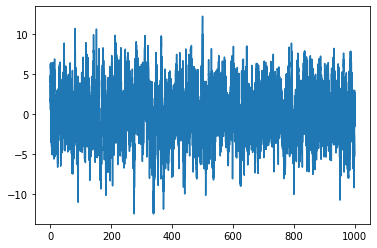

In [4]:
plt.plot(ttraj[:],vtraj[:])
plt.show()

Visualisation de la position au cours du temps $x(t)$.

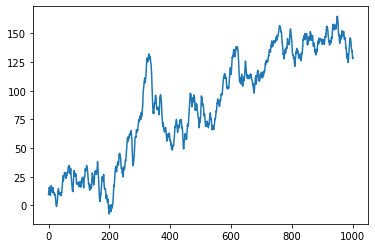

In [5]:
plt.plot(ttraj[:],xtraj[:])
plt.show()

### Spectre de puissance et fonction de corrélation par le théorème de Wiener-Khintchine

Dans cette partie on utilise les librairies fft de python pour calculer la fonction d'autocorrélation des vitesses $\langle v(0)v(t) \rangle$ par le théorème de Wiener-Khintchine.

In [6]:
varray=np.zeros(2*nsteps+1)
varray[0:nsteps]=vtraj
vfreq=fft.fft(varray)

spec=np.abs(vfreq)**2/nsteps

domega=2.*np.pi/h

freq=fft.fftfreq(2*nsteps+1)*domega

Visualisation du spectre de puissance

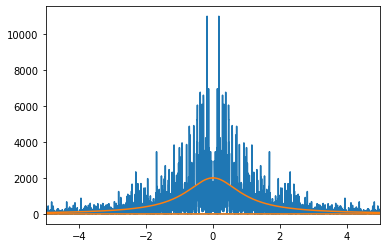

In [7]:
plt.plot(freq,np.real(spec))
plt.plot(freq,temperature/mass/gamma/(1+(freq/gamma)**2)*2/h)

plt.xlim(-5,5)
plt.show()

Calcul par transformée de Fourier inverse de la fonction d'autocorrélation et visualisation

In [8]:
correlation=fft.ifft(spec)
time=fft.fftfreq(2*nsteps+1)*h*(2*nsteps+1)

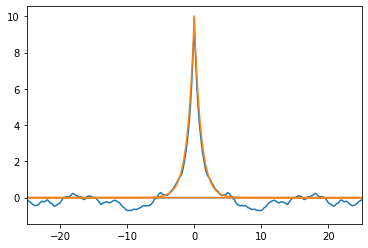

In [9]:
plt.plot(time,np.real(correlation))
plt.plot(time,temperature/mass*np.exp(-np.abs(time)*gamma))
plt.xlim(-25,25)
plt.show()


### Déplacement carré moyen

Calcul et visualisation du déplacement carré moyen $\langle (x(t)-x(0))^2 \rangle$ où la moyenne est une moyenne temporelle.

In [10]:
nmax=1000
msd=np.zeros(nmax)
time=np.arange(nmax)*h

for dh in tqdm(range(nmax)):
    xdiff=xtraj[dh:]-xtraj[:nsteps-dh]
    msd[dh]=np.mean(xdiff**2)

100%|██████████| 1000/1000 [00:00<00:00, 7241.66it/s]


Visualisation en échelle linéaire et comparaison avec la droite asymptotique. 
Le coefficient de diffusion est celui ontenu en TD.

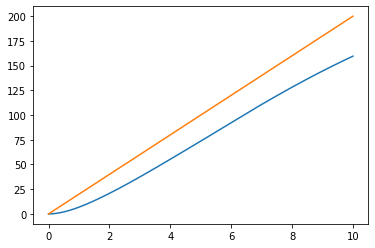

In [11]:
plt.plot(time,msd)
plt.plot(time,temperature/gamma*2*time)

plt.show()

Visualisation en échelle log-log. Remarquez que le régime diffusif est obtenu seulement à la fin de la simulation.

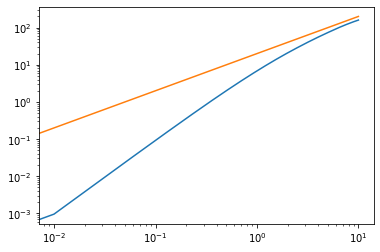

In [12]:
plt.plot(time,msd)
plt.plot(time,temperature/gamma*2*time)
plt.xscale('log')
plt.yscale('log')
plt.show()

## Moyennes d'ensemble

### Réponse à une force constante

$f_0$ est la force constante appliquée au système. Ici $f_0$ est choisi grand pour permettre la visualisation. La vitesse qui en résulte est grande devant la vitesse quadratique moyenne donnée par la temperature. Cela n'a pas d'impact ici car la réponse du système est strictement linéaire. Dans le cas général, on serait dans ces conditions dans un régime non-linéaire où la réponse linéaire ne s'applique pas.

Notez, que l'on passe à la fonction langevin_step une fonction force(x). Cela permet de rajouter une force extérieure qui dépend de la position, par exemple un potentiel harmonique par

    k=1
    def force(x):
        return -k*x
        
nsamples est le nombre de trajectoires simulées

In [13]:
f0=10
x0,v0=0.0,0.0

def force(x):
    return f0

nsteps=1000
nsamples=1000

h=0.01

xTraj=np.zeros([nsamples,nsteps])
vTraj=np.zeros([nsamples,nsteps])
tTraj=np.zeros([nsamples,nsteps])

for sample in tqdm(range(nsamples)):
    x,v=x0,v0

    for step in range (nsteps):
        xTraj[sample,step]=x
        vTraj[sample,step]=v
        tTraj[sample,step]=step*h
        x,v=lgv.langevin_step(x,v,h,gamma,sigma,mass,force)

100%|██████████| 1000/1000 [00:07<00:00, 135.80it/s]


Moyennes sur toutes les trajectoires

In [14]:
vTraj_aver=np.mean(vTraj,axis=0)
tTraj_aver=tTraj[0,:]

Visualisation de quelques trajeectoires et de la vitesse moyenne sur l'ensemble des trajectoires simulées.

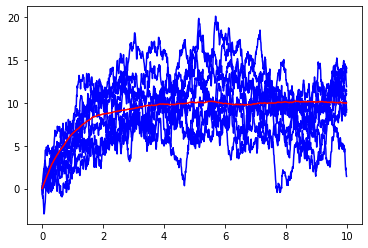

In [15]:
for i in range(0,nsamples,100):
    plt.plot(tTraj[i,:],vTraj[i,:],'b')
    
plt.plot(tTraj_aver,vTraj_aver,'r')

plt.show()

Comparaison de la vitesse moyenne observée et de la vitesse moyenne théorique.

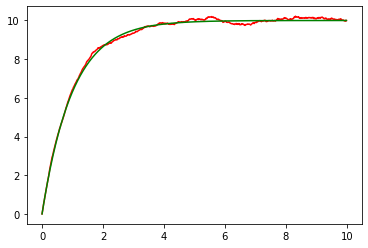

In [16]:
plt.plot(tTraj_aver,vTraj_aver,'r')
plt.plot(tTraj_aver,f0/gamma*(1-np.exp(-gamma*tTraj_aver)),'g')


plt.show()

### Etat transitoire

On part ici avec une vitesse v0 non nulle. La même remarque que pour l'application de la force est vraie ici aussi: v0 est en principe trop grand pour être dans le régime linéaire mais cela n'a pas d'impact sur ce modèle particulier.

In [17]:
x0,v0=0.0,15

nsteps=1000
nsamples=1000

h=0.01

xTraj=np.zeros([nsamples,nsteps])
vTraj=np.zeros([nsamples,nsteps])
tTraj=np.zeros([nsamples,nsteps])

for sample in tqdm(range(nsamples)):
    x,v=x0,v0

    for step in range (nsteps):
        xTraj[sample,step]=x
        vTraj[sample,step]=v
        tTraj[sample,step]=step*h
        x,v=lgv.langevin_step(x,v,h,gamma,sigma,mass)

100%|██████████| 1000/1000 [00:11<00:00, 88.17it/s]


Moyennes sur toutes les trajectoires

In [18]:
vTraj_aver=np.mean(vTraj,axis=0)
tTraj_aver=tTraj[0,:]

Visualisation de quelques trajeectoires et de la vitesse moyenne sur l'ensemble des trajectoires simulées.

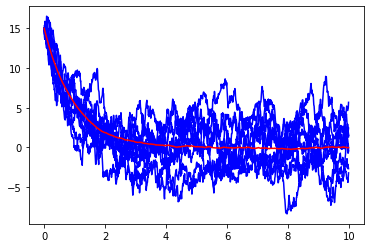

In [19]:
for i in range(0,nsamples,100):
    plt.plot(tTraj[i,:],vTraj[i,:],'b')
    
plt.plot(tTraj_aver,vTraj_aver,'r')

plt.show()

Comparaison de la vitesse moyenne observée et de la vitesse moyenne théorique.

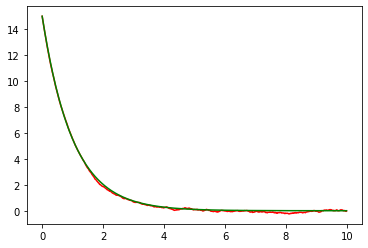

In [20]:
plt.plot(tTraj_aver,vTraj_aver,'r')
plt.plot(tTraj_aver,v0*np.exp(-gamma*tTraj_aver),'g')

plt.show()

Calcul de la densité de probabilité des vitesses au dernier pas de temps et comparaison avec la distribution théorique.

In [21]:
hist,bin_edges=np.histogram(vTraj[:,-1],bins=50,density=True)

v=(bin_edges[:-1]+bin_edges[1:])/2.0
dv=bin_edges[1]-bin_edges[0]

P=np.exp(-mass*v**2/(2.0*temperature))*np.sqrt(mass/(2.0*temperature*np.pi))

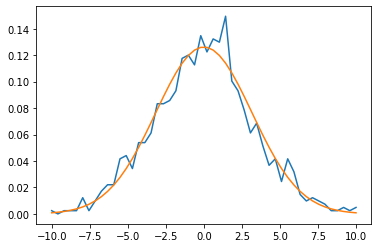

In [22]:
plt.plot(v,hist)
plt.plot(v,P)
plt.show()

### Processus à l'équilibre

Ici, comme dans la partie prise en main, on commence chaque trajectoire par une partie d'équilibration de ninit pas de temps avant d'accumuler les données.

In [23]:
nsteps=10000
nsamples=1000
ninit=2000

h=0.01

x0,v0=0.0,0.0

xTraj=np.zeros([nsamples,nsteps])
vTraj=np.zeros([nsamples,nsteps])
tTraj=np.zeros([nsamples,nsteps])

for sample in tqdm(range(nsamples)):
    x,v=x0,v0
    for step in range (ninit):
        x,v=lgv.langevin_step(x,v,h,gamma,sigma,mass)

    for step in range (nsteps):
        xTraj[sample,step]=x
        vTraj[sample,step]=v
        tTraj[sample,step]=step*h
        x,v=lgv.langevin_step(x,v,h,gamma,sigma,mass)

100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


### spectre de puissance et fonction d'autocorrélation de la vitesse

Même chose que dans la partie prise en main mais on effectue aussi une moyenne du spectre de puissance sur les trajectoires simulées. La comparaison avec les fonctions théoriques est bien meilleure.

In [24]:
vArray=np.zeros([nsamples,2*nsteps+1])
vArray[:,0:nsteps]=vTraj
vFreq=fft.fft(vArray)

Spec=np.abs(vFreq)**2/nsteps

Spec_aver=np.mean(Spec,axis=0)

domega=2.*np.pi/h

Freq=fft.fftfreq(2*nsteps+1)*domega

Visualisation du spectre de puissance.

La formule théorique utilisée est:
\begin{equation}
S(\omega)=\frac{kT}{m\gamma}\times\frac{1}{1+\left(\frac{\omega}{\gamma}\right)^2}\times\frac{2}{h}
\end{equation}

Notez que dans toute la page la constante de Boltzmann vaut $k=1$.

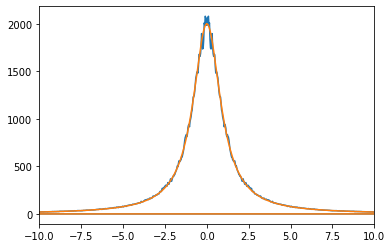

In [25]:
plt.plot(Freq,np.real(Spec_aver))
plt.plot(Freq,temperature/mass/gamma/(1+(Freq/gamma)**2)*2/h)

plt.xlim(-10,10)
plt.show()

Calcul et visualisation de la fonction d'autocorrélatiion des vitesses moyénnée sur le temps pour chaque trajectoire puis sur l'ensemble des trajectoires. 

La fonction d'autocorrélation théorique est

\begin{equation}
    C(t)=\frac{kT}{m} e^{-\gamma t}
\end{equation}

In [26]:
Correlation=fft.ifft(Spec_aver)
Time=fft.fftfreq(2*nsteps+1)*h*(2*nsteps+1)

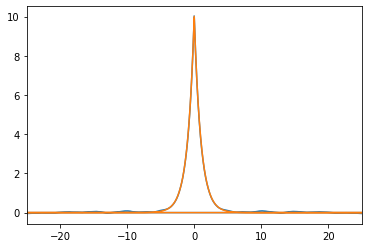

In [27]:
plt.plot(Time,np.real(Correlation))
plt.plot(Time,temperature/mass*np.exp(-np.abs(Time)*gamma))
plt.xlim(-25,25)
plt.show()


## A faire

Jouez! Changez h, x0, v0, nsteps, temperature etc.

Reprenez le transitoire avec $x_0=0$ et $v_0=0$ puis déterminer comme dans le TD la variance de $x(t)$ et la variance de $v(t)$